In [1]:
from pathlib import Path
import os
import sys
import itertools as it

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import picor as ic

from analysis_functions import analyse_rawfile, column_percentage

# Spectrum + time course

In [2]:
def calc_percentage(df, usecols):
    """Return dataframe of percentages of control experiment"""
    data = df.groupby("Exp").get_group("C")
    data = column_percentage(data, usecols=usecols) * 100
    data.drop(columns=["Rep", "Exp"], inplace=True)
    return data


def plot_time_course_corr_uncorr(dfs, usecols, ax):
    """Plot time course of both corrected and uncorrected data"""
    data_corr = calc_percentage(dfs["corr"], usecols=usecols).add_suffix(" corr")
    data_uncorr = calc_percentage(dfs["uncorr"], usecols=usecols).add_suffix(" uncorr")

    dashes = {key: (1, 1) for key in data_uncorr.keys()}

    sns.lineplot(data=data_corr, ax=ax, ci=None, dashes=False, legend="brief")
    sns.lineplot(data=data_uncorr, ax=ax, ci=None, dashes=dashes, legend="brief")
    sns.scatterplot(data=data_corr, ax=ax, markers=["o", "o","o"], s=25, legend=False)
    sns.scatterplot(data=data_uncorr, ax=ax, markers=["D", "D", "D"], s=25, legend=False)

    ax.set_ylabel("Isotopologue Abundance")
    fmt = "%.0f%%"  # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    sns.despine(ax=ax)
    plt.tight_layout()
    ax.get_legend().remove()

## Histone 3

In [3]:
molecule = "K(ac)QLATK(ac)AAR"

In [4]:
accucor_res = pd.read_excel("histone3/accucor_input_corrected.xlsx", sheet_name="Corrected")
accucor_res.drop(index=range(8,46), inplace=True)
accucor_res.index = ["No Label"] + [f"{i}C13" for i in range(1,8)]
accucor_res.drop(columns=["Compound", "C_Label"], inplace=True)
accucor_res.columns = ["AccuCor"]

In [5]:
spect = pd.read_csv("histone3//spectrum_heights.csv", index_col=0)

spect.columns = ["No Label"] + [f"{i}C13" for i in range(1,8)]

# Get abundances relative to heighest peak
m = spect.max().max()
spect = spect / m * 100

In [6]:
res = ic.calc_isotopologue_correction(spect, molecule_name=molecule, resolution_correction=True, resolution=60000)
res = res.transpose()
res.columns = ["PICor"]

In [7]:
data_input = spect.transpose()
data_input.columns = ["Peak Heights"]

In [8]:
comparison = pd.concat(
    [data_input, res, accucor_res], axis=1
)
comparison.index = [f"M+{i}" for i in range(8)]
comparison

,Peak Heights,PICor,AccuCor
M+0,60.675204,109.816292,108.641258
M+1,36.909273,0.000000,5.568223
M+2,100.000000,153.012417,153.003472
M+3,55.344305,0.000000,9.488295
M+4,54.063714,61.233765,61.376189
M+5,29.482191,6.466684,11.264568
M+6,18.936887,15.228486,15.869178
M+7,13.157303,9.528451,6.763924


In [9]:
comparison.to_csv("histone3/comparison_data.csv")

In [10]:
comparison = pd.read_csv("histone3/comparison_data.csv", index_col=0)
comparison.rename(columns={"Peak Heights": "Uncorrected"}, inplace=True)

In [11]:
#Timecourse data
infile = "histone3/200805_KQLATKAAR_ms-data.xlsx"

col_mapping = {
    "No label": "No Label",
    "2C13": "13C2",
    "4C13": "13C4",
}
all_col = list(col_mapping.values())

dfs = {}
dfs["uncorr"] = analyse_rawfile(infile, isotopologue_correction=False).rename(
    columns=col_mapping
)
dfs["corr"] = analyse_rawfile(infile, isotopologue_correction=True, resolution_correction=True).rename(
    columns=col_mapping
)

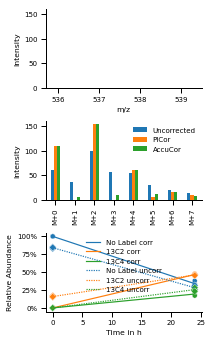

In [12]:
sns.set_context("paper", font_scale=0.8)
fig, axs = plt.subplots(nrows=3, figsize=(3.33, 5), sharex=False, sharey=False)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
axs[0].set_xlabel("m/z")

# Plot 1 left empty for spectrum pdf
axs[0].set_ylabel("Intensity")
axs[0].set_xlim((535.7,539.5))
axs[0].set_ylim((0, 160))

# Plot 2 for PICOR corrected data
comparison.plot.bar(ax=axs[1])
axs[1].legend(frameon=False, ncol=1)
axs[1].set_ylabel("Intensity")
axs[1].set_ylim((0, 160))

# Plot 3 for timecourse
plot_time_course_corr_uncorr(dfs, usecols=all_col, ax=axs[2])

axs[2].legend(frameon=False, ncol=1)
axs[2].set_ylabel("Relative Abundance")
sns.despine()
plt.tight_layout()
fig.savefig("histone3/spectrum_comparison.pdf")

## Acetyl-CoA

In [13]:
molecule = "acetyl-coa"

In [14]:
accucor_res = pd.read_excel("acetyl-coa/accucor/accucor_input_corrected.xlsx", sheet_name="Corrected")
accucor_res.index = ["No Label"] + [f"{i:0>2d}C13" for i in range(1,24)]
accucor_res.drop(columns=["Compound", "C_Label"], inplace=True)
accucor_res.columns = ["AccuCor"]

In [15]:
isocorrector_res = pd.read_csv("acetyl-coa/isocorrector/2021-07-16_180553/IsoCorrectoR_result_Corrected.csv")
isocorrector_res.index = ["No Label"] + [f"{i:0>2d}C13" for i in range(1,24)]
isocorrector_res.drop(columns=["Unnamed: 0"], inplace=True)
isocorrector_res.columns = ["IsoCorrectoR"]

In [16]:
isocor_res = pd.read_csv("acetyl-coa/isocor/data_corrected.csv", usecols=["isotopologue","corrected_area"], sep="\t")
isocor_res.index = ["No Label"] + [f"{i:0>2d}C13" for i in range(1,24)]
isocor_res.drop(columns=["isotopologue"], inplace=True)
isocor_res.columns = ["IsoCor"]

In [17]:
spect = pd.read_csv("acetyl-coa/ms_acetylcoa_data.csv", index_col=0)
spect.drop(columns=["compound", "replicate"], inplace=True)

# Get abundances relative to heighest peak
m = spect.max().max()
spect = spect / m * 100
spect = spect.loc["360min"].iloc[0]
factor = 100/max(spect)
spect.to_clipboard()

In [18]:
## Uncomment to calculate PICor correction
#res = ic.calc_isotopologue_correction(
#    spect,
#    molecule_name=molecule,
#    resolution_correction=True,
#    resolution=60000,
#    molecules_file="metabolites.csv",
#)

In [19]:
res = pd.read_csv("acetyl-coa/data_picor_corrected.csv", index_col=0)
res = res.loc["360min"].iloc[0]
res.name = "PICor"
res = res.transpose()
res

No Label    10.316521
01C13        0.000000
02C13       10.247026
03C13        0.000000
04C13        0.000000
05C13        5.038936
06C13        1.125964
07C13        5.749872
08C13        0.764366
09C13        0.098434
10C13        0.000000
11C13        0.372023
12C13        0.207100
13C13        0.000000
14C13        0.000000
15C13        0.000000
16C13        0.000922
17C13        0.019494
18C13        0.002613
19C13        0.020526
20C13        0.000000
21C13        0.000000
22C13        0.000000
23C13        0.000000
Name: PICor, dtype: float64

In [20]:
data_input = spect.transpose()
data_input.name = "Uncorrected"

In [21]:
comparison = pd.concat(
    [data_input, res, accucor_res, isocorrector_res, isocor_res], axis=1
)
comparison.index = [f"M+{i}" for i in range(24)]
comparison = comparison.iloc[0:13]*factor # Scales heighest uncorr peak to 100
comparison

,Uncorrected,PICor,AccuCor,IsoCorrectoR,IsoCor
M+0,85.340333,123.574457,123.620438,123.746019,96.515406
M+1,26.317815,0.000000,1.959272,1.912814,25.494120
M+2,100.000000,122.742020,125.382839,125.426396,103.612170
M+3,27.084337,0.000000,0.000000,0.000000,23.351727
M+4,2.494796,0.000000,0.000000,0.000000,0.000000
M+5,46.303817,60.357924,60.468370,60.504362,50.073505
M+6,22.741012,13.487145,15.940383,15.907474,23.168214
M+7,59.878862,68.873730,70.375770,70.415172,62.572247
M+8,22.199681,9.155808,11.467779,11.445309,20.286944
M+9,9.538350,1.179076,2.517133,2.470786,4.652160


In [22]:
comparison.to_csv("acetyl-coa/comparison_data.csv")

In [23]:
comparison = pd.read_csv("acetyl-coa/comparison_data.csv", index_col=0)
comparison

,Uncorrected,PICor,AccuCor,IsoCorrectoR,IsoCor
M+0,85.340333,123.574457,123.620438,123.746019,96.515406
M+1,26.317815,0.000000,1.959272,1.912814,25.494120
M+2,100.000000,122.742020,125.382839,125.426396,103.612170
M+3,27.084337,0.000000,0.000000,0.000000,23.351727
M+4,2.494796,0.000000,0.000000,0.000000,0.000000
M+5,46.303817,60.357924,60.468370,60.504362,50.073505
M+6,22.741012,13.487145,15.940383,15.907474,23.168214
M+7,59.878862,68.873730,70.375770,70.415172,62.572247
M+8,22.199681,9.155808,11.467779,11.445309,20.286944
M+9,9.538350,1.179076,2.517133,2.470786,4.652160


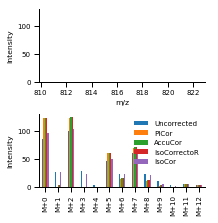

In [24]:
sns.set_context("paper", font_scale=0.8)
fig, axs = plt.subplots(nrows=2, figsize=(3.33, 2/3*5), sharex=False, sharey=False)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
axs[0].set_xlabel("m/z")
# plt.ylabel("Relative Abundance")

# Plot 1 left empty for spectrum pdf
axs[0].set_ylabel("Intensity")
axs[0].set_xlim((809.87, 822.93))
axs[0].set_ylim((0, 130))

# Plot 2 for PICOR corrected data
comparison.plot.bar(ax=axs[1])
axs[1].legend(frameon=False, ncol=1)
axs[1].set_ylabel("Intensity")
axs[1].set_ylim((0, 130))

# ax.set_ylabel("Abundance")
# plt.xticks(rotation=0)
# ax.set_xlabel("X")
sns.despine()
plt.tight_layout()
fig.savefig("acetyl-coa/spectrum_comparison.pdf")